In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # There's a PyTorch implementation but for Tensors.

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vincentleonardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincentleonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vincentleonardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import pandas as pd

df = pd.read_csv('~/Downloads/reddit_mbti.csv')

In [3]:
import re

def mbti_extract(text):
    if re.search('(infp|INFP)', text):
        return 'INFP'
    elif re.search('(enfp|ENFP)', text):
        return 'ENFP'
    elif re.search('(istj|ISTJ)', text):
        return 'ISTJ'
    elif re.search('(istp|ISTP)', text):
        return 'ISTP'
    elif re.search('(isfj|ISFJ)', text):
        return 'ISFJ'
    elif re.search('(isfp|ISFP)', text):
        return 'ISFP'
    elif re.search('(infj|INFJ)', text):
        return 'INFJ'
    elif re.search('(intj|INTJ)', text):
        return 'INTJ'
    elif re.search('(intp|INTP)', text):
        return 'INTP'
    elif re.search('(estp|ESTP)', text):
        return 'ESTP'
    elif re.search('(estj|ESTJ)', text):
        return 'ESTJ'
    elif re.search('(esfp|ESFP)', text):
        return 'ESFP'
    elif re.search('(esfj|ESFJ)', text):
        return 'ESFJ'
    elif re.search('(enfj|ENFJ)', text):
        return 'ENFJ'
    elif re.search('(entp|ENTP)', text):
        return 'ENTP'
    elif re.search('(entj|ENTJ)', text):
        return 'ENTJ'
    else:
        return None

df['MBTI'] = df.flair_text.apply(mbti_extract)


In [4]:
df = df.dropna()

<AxesSubplot:title={'center':'MBTI Type Distribution (Reddit Dataset)'}, xlabel='MBTI Type', ylabel='Count'>

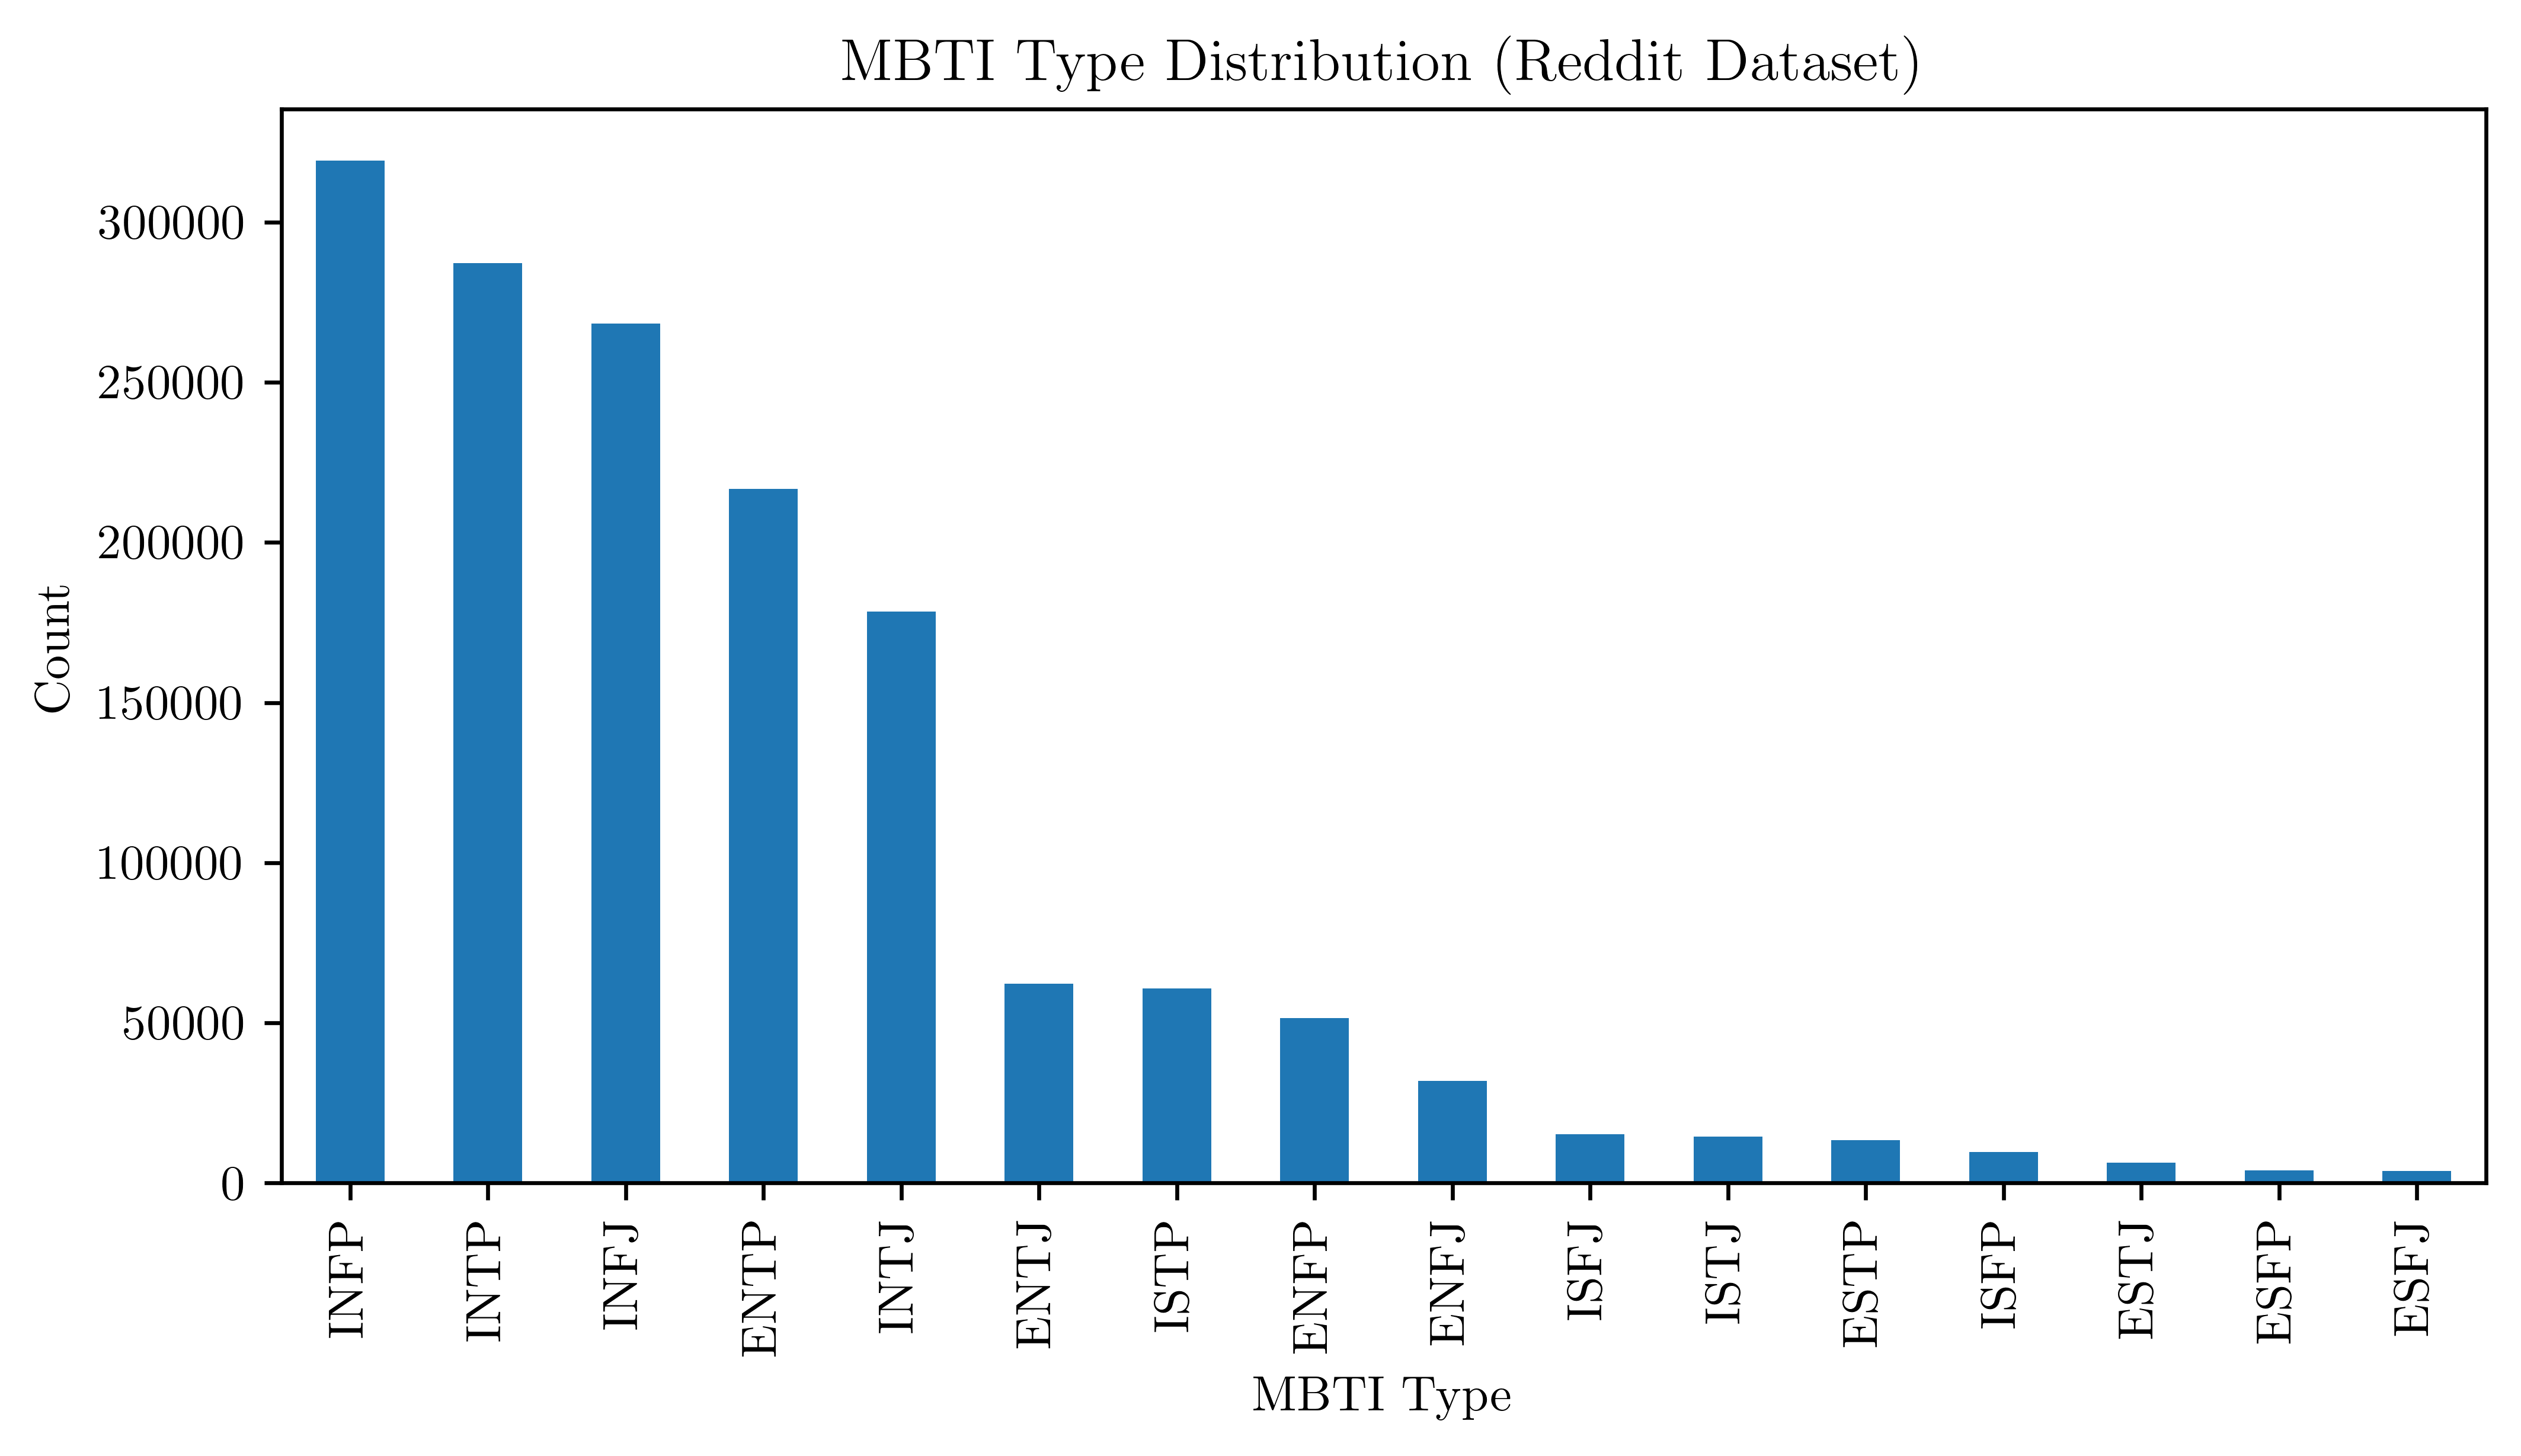

In [5]:
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(8,4), dpi=600)
plt.title("MBTI Type Distribution (Reddit Dataset)")
plt.xlabel("MBTI Type")
plt.ylabel("Count")

df.MBTI.value_counts().plot.bar()

<AxesSubplot:ylabel='Frequency'>

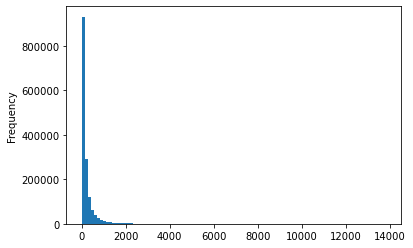

In [39]:
df.body.str.len().plot.hist(bins=100)

In [40]:
# Prerequisites for this function
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import contractions

def preprocessing(text):
    """Preprocessing each row of text
    
    List of things done:
    - Lower casing
    - Remove URL links
    - Remove mention/hashtags (@anonymous, #anonymous)
    - Remove accented characters (changing to ASCII from UTF-8)
    - Remove punctuations, numbers, and irrelevant characters
    - Remove excess whitespace
    - Remove stop words in English
    - Normalise and lemmatise
    - Remove single characters
    
    Possible improvements:
    - Separating words from numbers (if it exists)
    - Convert emoji and chat lingo with proper form
    

    Args:
        text (str): String of text that needs to be preprocessed
    """
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub("@\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    # text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = [contractions.fix(word) for word in text.split()]
    text = ' '.join([word for word in text])
    text = re.sub(r'[^a-zA-Z]', ' ', text) # re.sub(r'[^a-zA-Z0-9]', ' ', text) if we want numeric characters
    text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
    # text = word_tokenize(text)
    # text = [token for token in text if token not in stopwords.words('english')]
    # text = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    # text = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text]
    # text = [word for word in text if len(word) > 1]
    # text = ' '.join([word for word in text])
    return text

In [41]:
df['body'] = df.body.apply(preprocessing)

In [44]:
df['body'] = df.body.str.lower()

In [48]:
df = df[df.body != '']

In [49]:
embed_size = 300 # how big is each word vector
max_features = 40000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [61]:
# Prerequisites
from sklearn.preprocessing import LabelEncoder

def keras_tokenizer(train_X, test_X):
    """Tokenize and pad the split train and test features

    Args:
        train_X (array): Training features
        test_X (array): Test features
    """    
    
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)
    
    # Pad the sentences
    train_X = pad_sequences(train_X)
    test_X = pad_sequences(test_X)
    
    return train_X, test_X, tokenizer

def label_encoder(train_y, test_y):
    le = LabelEncoder()
    train_y = le.fit_transform(train_y.values)
    test_y = le.transform(test_y.values)
    
    return train_y, test_y, le

def load_fasttext(word_index):
    
    EMBEDDING_FILE = 'input/wiki-news-300d-1M.vec'
    
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" "))
                            for o in open(EMBEDDING_FILE) 
                            if len(o)>100 and o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit
    
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [58]:
from sklearn.model_selection import train_test_split

X_train_exploded, X_test_exploded, y_train_exploded, y_test_exploded = train_test_split(df.body, 
                                                                                        df.MBTI, random_state=0,
                                                                                        test_size=0.3)

In [59]:
X_train_exploded, X_test_exploded, tokenizer = keras_tokenizer(X_train_exploded, X_test_exploded)
y_train_exploded, y_test_exploded, le = label_encoder(y_train_exploded, y_test_exploded)

In [62]:
embedding_matrix = load_fasttext(tokenizer.word_index)

/opt/homebrew/Caskroom/miniforge/base/envs/env_datasci/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [65]:
n_epochs = 30
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model#.cuda()

def training(trg_train_X, trg_train_y, trg_test_X, trg_test_y):

    # Load train and test in CUDA Memory
    x_train = torch.tensor(trg_train_X, dtype=torch.long)#.cuda()
    y_train = torch.tensor(trg_train_y, dtype=torch.long)#.cuda()
    x_cv = torch.tensor(trg_test_X, dtype=torch.long)#.cuda()
    y_cv = torch.tensor(trg_test_y, dtype=torch.long)#.cuda()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)

    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    train_loss = []
    valid_loss = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Set model to train configuration
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Predict/Forward Pass
            y_pred = model(x_batch)
            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
        
        # Set model to validation configuration -Doesn't get trained here
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(x_cv),len(le.classes_)))
        
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
        
        # Check Accuracy
        val_accuracy = sum(val_preds.argmax(axis=1)==trg_test_y)/len(trg_test_y)
        train_loss.append(avg_loss)
        valid_loss.append(avg_val_loss)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                    epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    
    return model

In [66]:
training(X_train_exploded, y_train_exploded, X_test_exploded, y_test_exploded)

KeyboardInterrupt: 